### **Backtesting**

This tutorial demonstrates how to backtest an optimized portfolio.

### **Introduction**

This tutorial guides you through the process of evaluating a portfolio's performance using backtesting techniques. We analyze historical stock data, compute returns, and assess performance using different backtesting methods. The goal is to understand how a given portfolio would have performed under past market conditions and compare it with benchmarks.

By the end of this tutorial, you will be able to:
- Define and apply a **backtesting methodology**.
- Evaluate portfolio performance against **benchmarks**.
- Visualize the **backtest results**.

#### **Importing Required Libraries**

Before diving into portfolio optimization and backtesting, we need to import the necessary libraries.

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Import modules from cuFOLIO and cuOpt
from cufolio import cvar_optimizer, cvar_utils, utils, backtest
from cuopt import linear_programming
from cuopt.linear_programming.solver_settings import PDLPSolverMode
from cuopt.linear_programming.solver.solver_parameters import *

#### **1. Global Configurations and Problem Setup**

This section defines global settings and parameters for the backtesting process. This includes:
-   **CVaR Optimization Parameters** for the initial portfolio construction.
-   **Dataset Selection**.
-   **Market Scenario Definitions** and selection for the in-sample (training) period.
-   **Out-of-Sample Period Definition** for testing.
-   **GPU Solver Settings** for optimization.

**CVaR Optimization Parameters Explanation:**
-   **Portfolio Constraints:**
    * `w_min`, `w_max`: Minimum and maximum asset weights.
    * `c_min`, `c_max`: Minimum and maximum cash holdings.
    * `L_tar`: Leverage constraint, restricting the total long/short positions in the portfolio.
-   **Risk Constraints:**
    * `risk_aversion`: Penalization factor for risk, controlling the trade-off between return and risk (higher values prioritize lower risk).
    * `confidence`: The percentile (e.g., 95% or 99%) beyond which the average loss is computed.
    * `num_scen`: Number of simulated return scenarios.
-   **Optional Constraints:**
    * `T_tar`: Turnover constraint (not used in this notebook, set to `None`).
    * `cvar_limit`: Strict constraint on Conditional Value-at-Risk (CVaR).
-   **Fitting Method:**
    * `fit_type`: Method for estimating return distributions (`'kde'`, `'gaussian'`, `'historical'`).

In [2]:
# --- CVaR Optimization Parameters for Portfolio Construction ---
# These parameters are used for the initial in-sample portfolio optimization
backtest_cvar_params = cvar_optimizer.CVaR_Parameters(
    w_min=-0.3, w_max=0.8,        # Asset weight allocation bounds
    c_min=0.1, c_max=0.4,         # Cash holdings bounds
    L_tar=1.6, T_tar=None,        # Leverage & Turnover (None for this backtest)
    cvar_limit=0.1,               # Max CVaR (None = unconstrained)
    risk_aversion=0.5,            # Risk aversion level (0 = maximize return subject to risk constraints)
    confidence=0.95,              # CVaR confidence level (alpha)
    num_scen=10000,               # Number of return scenarios for simulation
    fit_type="gaussian"           # Return distribution estimation method
)

# --- Dataset Configuration ---
DATASET_NAME = "sp500"
DATASET_FILE_PATH = f"../data/stock_data/{DATASET_NAME}.csv"

# --- Market Scenario Definitions ---
# Users can add or modify scenarios here for different in-sample periods
SCENARIO_DEFINITIONS = {
    'pre_crisis': ('2005-01-01', '2007-10-01'),
    'crisis': ('2007-10-01', '2009-04-01'),
    'post_crisis': ('2009-06-30', '2014-06-30'),
    'oil_price_crash': ('2014-06-01', '2016-03-01'),
    'FAANG_surge': ('2015-01-01', '2021-01-01'),
    'covid': ('2020-01-01', '2023-01-01'),
    'recent': ('2022-01-04', '2024-01-01') # Default scenario for this run
}

# --- Configuration for this Specific Backtest Run ---
# Select the scenario key for the in-sample optimization period
SELECTED_SCENARIO_KEY = 'recent'
# Define the end date for the out-of-sample testing period
OUT_OF_SAMPLE_END_DATE_STR = "2024-07-01" # This extends beyond the selected scenario's end date for OOS testing
RETURN_TYPE = "LOG"                       # Type of returns to calculate
KDE_COMPUTATION_DEVICE = "GPU"            # Device for KDE computation ("GPU" or "CPU")
# --- End of Run Configuration ---

# Extract in-sample dates from the selected scenario
if SELECTED_SCENARIO_KEY not in SCENARIO_DEFINITIONS:
    raise ValueError(f"Error: Scenario key '{SELECTED_SCENARIO_KEY}' not found in SCENARIO_DEFINITIONS.")
in_sample_start_date_str, in_sample_end_date_str = SCENARIO_DEFINITIONS[SELECTED_SCENARIO_KEY]

# Define the regime for portfolio optimization (in-sample period)
optimization_regime_dict = {
    "name": SELECTED_SCENARIO_KEY,
    "range": (in_sample_start_date_str, in_sample_end_date_str)
}

# Compute returns for the optimization period (in-sample)
optimization_returns = cvar_utils.calculate_returns(
    DATASET_FILE_PATH,
    optimization_regime_dict,
    RETURN_TYPE,
    backtest_cvar_params,         # CVaR parameters defined above
    device=KDE_COMPUTATION_DEVICE
)

# Instantiate CVaR optimization problem for the in-sample data
cvar_optimizer_problem = cvar_optimizer.CVaR(
    returns_dict=optimization_returns,
    cvar_params=backtest_cvar_params
)

# --- Global GPU Solver Settings ---
# Initialize solver settings for GPU (defined once for the notebook)
gpu_solver_settings = linear_programming.SolverSettings()
gpu_solver_settings.set_parameter(CUOPT_PDLP_SOLVER_MODE, PDLPSolverMode.Stable2)
gpu_solver_settings.set_optimality_tolerance(1e-4)              # Define optimality tolerance
gpu_solver_settings.set_parameter(CUOPT_TIME_LIMIT, 10)         # Set time limit (seconds)
gpu_solver_settings.set_parameter(CUOPT_LOG_TO_CONSOLE, False)  # Disable console logging

#### **2. Solve the Optimization Problem on GPU**

This section solves the CVaR optimization problem using the GPU-accelerated solver to obtain the optimal portfolio based on the in-sample data.

In [3]:
# Solve the optimization problem using the configured GPU solver settings
# This yields the status of the optimization and the optimal portfolio (weights)
optimization_status, optimal_gpu_portfolio = cvar_optimizer_problem.solve_optimization_problem(
    device="GPU",
    gpu_settings=gpu_solver_settings # Using globally defined settings
)
# The solve_optimization_problem method will print the GPU CVaR results and optimal portfolio details.

*************************
--- GPU CVaR Results---
recent: ('2022-01-04', '2024-01-01')
Scenarios: 10000
solver time: 0.0003 seconds
IO time: 0.4826 seconds
--- Optimal Portfolio ---
Long--CAH: 0.057
Short--EL: -0.037
Long--FICO: 0.636
Short--ILMN: -0.163
Long--LLY: 0.407
Short--MTCH: -0.3
cash: 0.4
*************************



#### **3. Run Backtest**

This section evaluates the performance of the optimized portfolio (`optimal_gpu_portfolio`) over a historical period that includes both the in-sample optimization period and a subsequent out-of-sample testing period.

**Parameters for `portfolio_backtester`:**
-   `test_portfolio`: The `Portfolio` object (e.g., `optimal_gpu_portfolio`) to be evaluated.
-   `returns_dict`: A dictionary containing returns data covering the entire period for backtesting and plotting (in-sample start to out-of-sample end).
-   `risk_free_rate`: The risk-free rate for calculations like the Sharpe ratio.
-   `test_method`: The method for backtesting (`'historical'`, `'kde_simulation'`, `'gaussian_simulation'`).
-   `benchmark_portfolios`: Optional DataFrame or dictionary of benchmark portfolios.

##### **3.1. Constructing the Full Returns Dictionary for Backtesting**

We prepare the returns data covering the entire period (in-sample start to out-of-sample end) to facilitate a comprehensive backtest and visualization across both phases.

In [4]:
# Define the regime for the full data required for backtesting
# This range spans from the beginning of the in-sample period to the end of the out-of-sample period.
# This allows the plot to show both in-sample behavior of the optimized portfolio and its out-of-sample performance.
full_data_regime_name = f"{SELECTED_SCENARIO_KEY}_to_{OUT_OF_SAMPLE_END_DATE_STR.replace('-', '')}"
full_data_regime_dict = {
    "name": full_data_regime_name, # Descriptive name for the full period
    "range": (in_sample_start_date_str, OUT_OF_SAMPLE_END_DATE_STR),
}

# Compute returns for the full backtesting period
# Note: backtest_cvar_params are passed for consistency in potential KDE fitting,
# though only the 'num_scen' and 'fit_type' are strictly used by calculate_returns if KDE is involved.
full_returns_for_backtest = cvar_utils.calculate_returns(
    DATASET_FILE_PATH,
    full_data_regime_dict,
    RETURN_TYPE,
    backtest_cvar_params,                # Using the same CVaR params for consistency in data handling
    device=KDE_COMPUTATION_DEVICE
)

# --- Backtesting Configuration ---
# Define the backtesting method
BACKTEST_METHOD = "historical" # Options: 'historical', 'kde_simulation', 'gaussian_simulation'

# Set the risk-free rate (e.g., for Sharpe ratio calculation)
RISK_FREE_RATE = 0.0

##### **(Optional) Creating Benchmark Portfolios**

Users can define custom benchmark portfolios for comparison. Each benchmark should specify asset allocations (weights) and a cash allocation. The `cvar_utils.generate_user_input_portfolios()` function converts this into a usable format.

**Example:**
-   `NVDA-JPM`: 72% NVIDIA, 18% JPMorgan, 10% cash.
-   `AAPL-MSFT`: 29% Apple, 61% Microsoft, 10% cash.

To use benchmarks, uncomment and modify the code below. Ensure assets are present in the dataset.

In [ ]:
# # Example: Define user-input benchmark portfolios dictionary
# user_defined_benchmarks_dict = {
# # 'NVDA-JPM': ({'NVDA': 0.72, 'JPM': 0.18}, 0.1), # (asset_weights_dict, cash_holding_float)
# # 'AAPL-MSFT': ({'AAPL': 0.29, 'MSFT': 0.61}, 0.1),
#     # Add more benchmarks as needed
# }

# # Convert user-defined portfolios into the required format for the backtester
# # The `full_returns_for_backtest` dictionary is used to ensure assets are known
# benchmark_portfolios_for_backtest = None # Initialize as None

# # Check if user_defined_benchmarks_dict is defined and not empty
# if 'user_defined_benchmarks_dict' in globals() and user_defined_benchmarks_dict:
#     try:
#         benchmark_portfolios_for_backtest = cvar_utils.generate_user_input_portfolios(
#             user_defined_benchmarks_dict, full_returns_for_backtest
#     )
#     except Exception as e:
# print(f"Error generating benchmark portfolios: {e}. Check asset names and data availability.")
#         benchmark_portfolios_for_backtest = None # Reset if error
# else:
# print("No user-defined benchmarks provided or dictionary is empty.")
#     benchmark_portfolios_for_backtest = None

##### **3.2. Running the Portfolio Backtest**

This step initializes and runs the `portfolio_backtester`. The `cut_off_date` (which is `in_sample_end_date_str`) is critical for distinguishing between the in-sample optimization period and the out-of-sample testing period in the performance analysis and plots.

In [5]:
# Define the cut-off date for backtesting (this is the end of the in-sample optimization period)
backtest_cut_off_date = in_sample_end_date_str

# Ensure the optimal_gpu_portfolio from step 2 is available
if 'optimal_gpu_portfolio' not in globals():
    raise NameError("Variable 'optimal_gpu_portfolio' is not defined. Please run cell 7 (Solve the Optimization Problem).")

# Initialize the portfolio backtester
portfolio_evaluator = backtest.portfolio_backtester(
    test_portfolio=optimal_gpu_portfolio,
    returns_dict=full_returns_for_backtest, # Using returns covering the full period
    risk_free_rate=RISK_FREE_RATE,
    test_method=BACKTEST_METHOD,
    # benchmark_portfolios=benchmark_portfolios_for_backtest,  # Uncomment to include benchmarks
    benchmark_portfolios=None, # Set to None if no benchmarks defined or if there was an error generating them
)

# Run the backtest and retrieve the performance summary DataFrame
# `plot_returns=False` here, as a dedicated plotting function is used in the next step
backtest_summary_df, _ = portfolio_evaluator.backtest_against_benchmarks(
    plot_returns=False,
    cut_off_date=backtest_cut_off_date
)

# Display backtesting results summary
print("Backtest Performance Summary:")
backtest_summary_df

Backtest Performance Summary:


,returns,cumulative returns,mean portfolio return,sharpe,sortino,max drawdown
portfolio name,,,,,,
GPU_optimal,"[-0.016977462182742865, 0.016832695694282637, ...","[0.9831658427973088, 0.9998552439897023, 1.002...",0.002981,2.760036,4.809903,0.108896
equal-weight,"[-0.00890644828151313, 0.0007397801512687982, ...","[0.991133096640298, 0.9918665885103696, 0.9900...",0.000014,0.033638,0.05082,0.130163


##### **3.3. Visualizing Backtest Results**

This section generates a performance plot for the optimized portfolio. The visualization helps assess how the portfolio performed over time, distinguishing between the in-sample and out-of-sample periods using the `cut_off_date`.

**Plotting Parameters:**
-   `portfolio`: The optimized portfolio (`optimal_gpu_portfolio`).
-   `backtester`: The initialized `portfolio_evaluator` object from the previous step.
-   `cut_off_date`: The date separating in-sample and out-of-sample periods.
-   `backtest_plot_title`: Title for the generated plot.

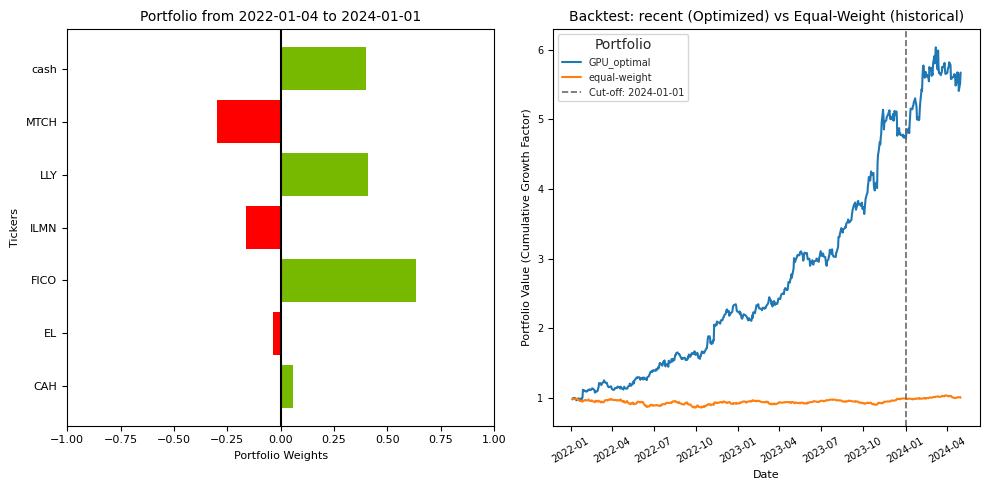

In [6]:
# Generate and display the backtest performance plot
# This plot will show performance from in_sample_start_date_str to OUT_OF_SAMPLE_END_DATE_STR,
# with a distinction at the backtest_cut_off_date.
plot_title = f"Backtest: {SELECTED_SCENARIO_KEY} (Optimized) vs Equal-Weight ({BACKTEST_METHOD})"

utils.portfolio_plot_with_backtest(
    portfolio=optimal_gpu_portfolio,
    backtester=portfolio_evaluator,
    cut_off_date=backtest_cut_off_date,
    backtest_plot_title=plot_title,
)

---
SPDX-FileCopyrightText: Copyright (c) 2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
SPDX-License-Identifier: MIT
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.